In [17]:
### IMPORTS ###
import os
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, fixed
import ipywidgets as widgets

In [15]:
### SETTINGS ###
np.set_printoptions(precision=20, suppress=True, threshold=np.inf)

In [18]:
### FOLDER SETTINGS ###
input_folder = "../output/"

file_solution_path = input_folder + "/system_solution.dat"
residual_path = input_folder + "/residual_solution.dat"

In [16]:
format_string = '<d'  # '<d' for little-endian, '>d' for big-endian

In [20]:
### Analytical solution functions ###

def true_function(X,Y):
    
    # u = np.sin(X)*np.cos(Y)
    # u_x = np.cos(X) * np.cos(Y)
    # u_y = -np.sin(X) * np.sin(Y)
    # u_xy = -np.sin(Y) * np.cos(X)
    # u_xx = -np.sin(X) * np.cos(Y)
    # u_yy = -np.sin(X) * np.cos(Y)

    u = 3*X**2 + 2*X*Y**2 + Y**3 - 4*Y + 7 + np.exp(3*X)*Y**2 + np.sin(2*Y)*np.cos(3*X)
    u_x = 6*X + 3*Y**2*np.exp(3*X) + 2*Y**2 - 3*np.sin(3*X)*np.sin(2*Y)
    u_y = 4*X*Y + 3*Y**2 + 2*Y*np.exp(3*X) + 2*np.cos(3*X)*np.cos(2*Y) - 4
    u_xy = 6*Y*np.exp(3*X) + 4*Y - 6*np.sin(3*X)*np.cos(2*Y)
    u_xx = 9*Y**2*np.exp(3*X) - 9*np.sin(2*Y)*np.cos(3*X) + 6
    u_yy = 4*X + 6*Y + 2*np.exp(3*X) - 4*np.sin(2*Y)*np.cos(3*X)
    
    return u, u_x, u_y, u_xy, u_xx, u_yy


In [14]:
def plot_function(X, Y, approximate_u, true_u, approximate_derivative, true_derivative):

    solution_max_error = np.abs(approximate_u - true_u)
    solution_l2_error = np.linalg.norm(approximate_u - true_u, 2)

    derivative_max_error = np.abs(approximate_derivative - true_derivative)
    derivative_l2_error = np.linalg.norm(approximate_derivative - true_derivative, 2)
    
    #print(f"Function error: {np.max(solution_max_error):.1e} {solution_l2_error:.1e}")
    print(f"Derivative error: {np.max(derivative_max_error):.1e} {derivative_l2_error:.1e}")

    # Create the figure for 3D surface plots
    fig = plt.figure(figsize=(15, 20))

    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.plot_surface(X, Y, approximate_u, cmap='viridis')
    ax1.set_title('Approximate u')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    ax2.plot_surface(X, Y, true_u, cmap='viridis')
    ax2.set_title('u')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    ax3.plot_surface(X, Y, np.abs(approximate_u - true_u), cmap='viridis')
    ax3.set_title('Error aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')

    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    ax4.plot_surface(X, Y, approximate_derivative, cmap='viridis')
    ax4.set_title('Approximate derivative')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')

    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    ax5.plot_surface(X, Y, true_derivative, cmap='viridis')
    ax5.set_title('Derivative')
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')

    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    ax6.plot_surface(X, Y, np.abs(approximate_derivative - true_derivative), cmap='viridis')
    ax6.set_title('Error aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
    ax6.set_xlabel('x')
    ax6.set_ylabel('y')

    # Adjust the spacing between the plots
    #plt.subplots_adjust(wspace=1, hspace=1)
    #plt.tight_layout()
    plt.show()

    return

In [19]:
with open(file_solution_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)

    approximate_solution = data

with open(residual_path, 'rb') as f:
    data = np.fromfile(f, dtype=np.float64)

    residual = data

approximate_solution = np.array(approximate_solution)
residual = np.array(residual)

In [21]:
ndims = 2
num_data_per_elements = 1
grid_size = [128,128]

domain_begin_array = np.full(ndims, -2.0)
domain_end_array = np.full(ndims, 2.0)

layout = (grid_size[0], grid_size[1], num_data_per_elements)

# Create coordinate arrays for each dimension
x = np.linspace(domain_begin_array[0], domain_end_array[0], grid_size[0])
y = np.linspace(domain_begin_array[1], domain_end_array[1], grid_size[1])

# Generate meshgrid from coordinate arrays
X, Y = np.meshgrid(x, y, indexing='ij')

In [22]:
approximate_solution = approximate_solution.reshape(layout)
residual = residual.reshape(layout)

approximate_solution = np.squeeze(approximate_solution)
residual = np.squeeze(residual)

In [24]:
u, u_x, u_y, u_xy, u_xx, u_yy = true_function(X,Y)

Derivative error: 1.3e+01 1.4e+02


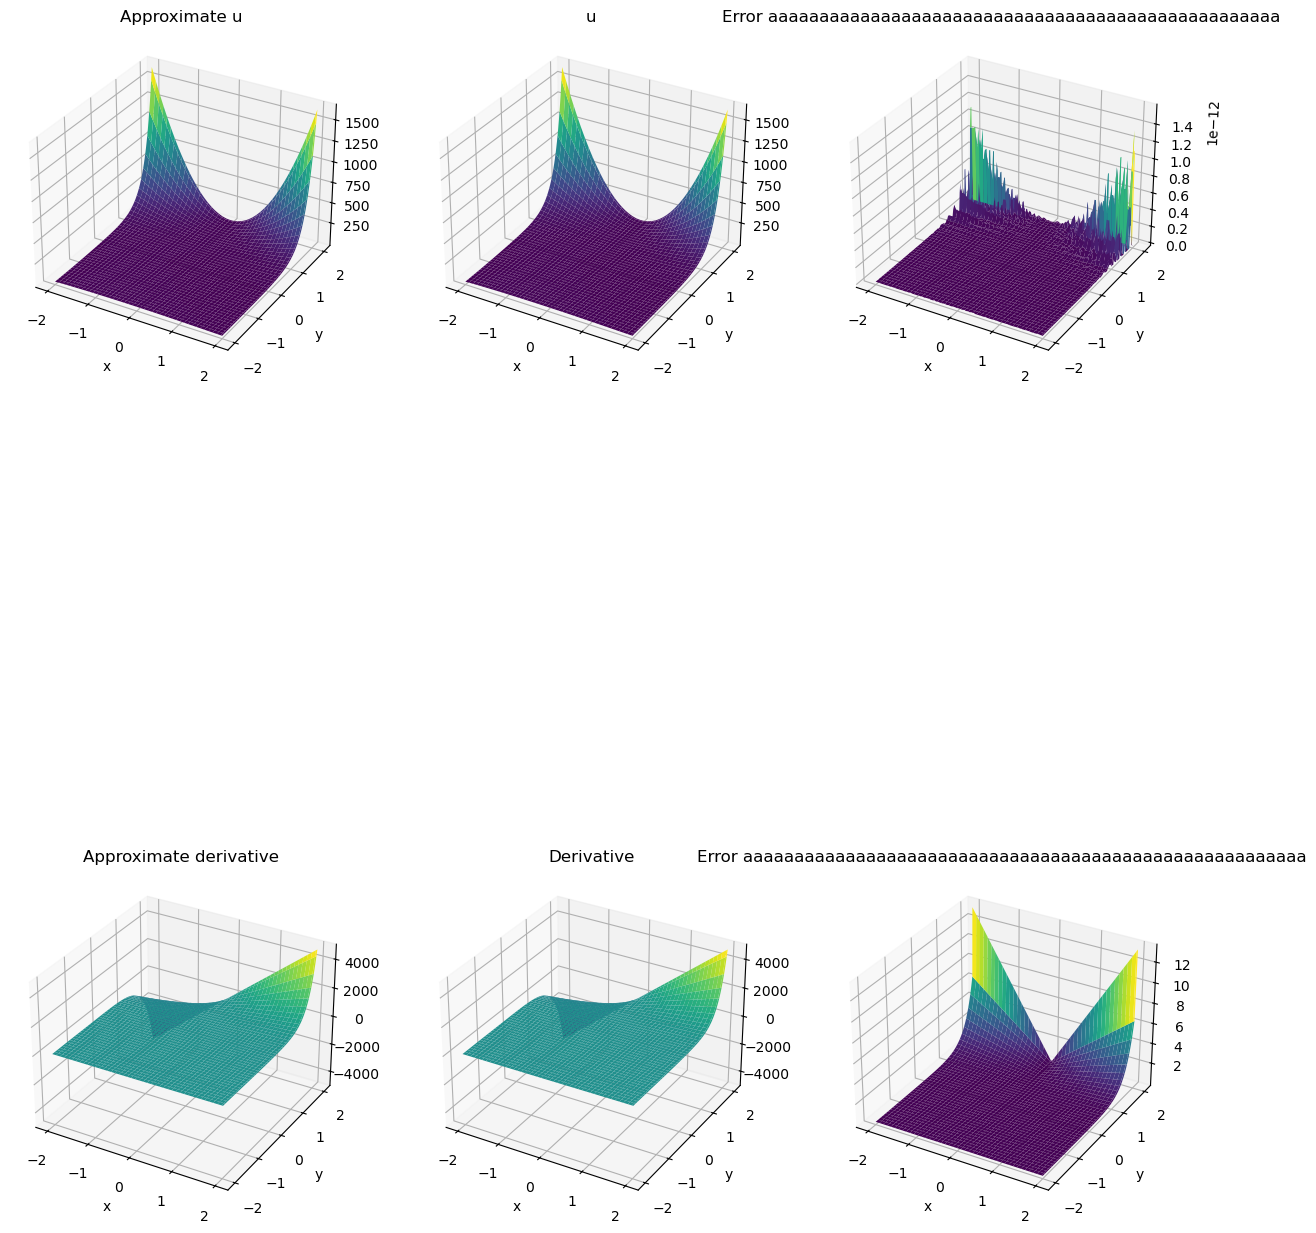

In [23]:
plot_function(X, Y, approximate_solution, u, residual, u_xy)

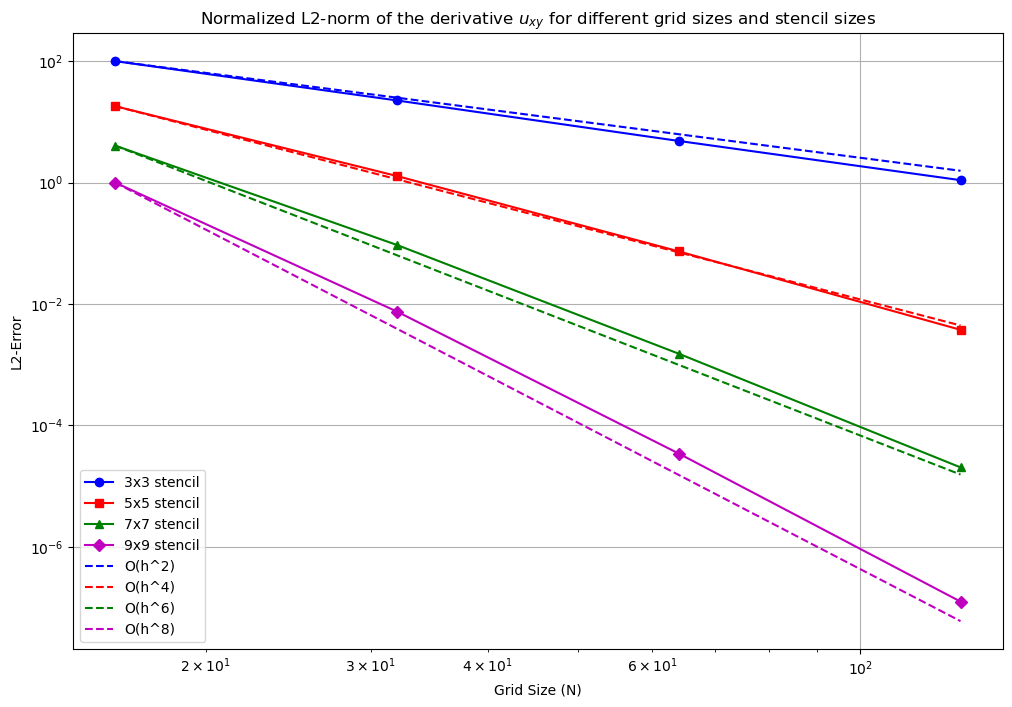

In [25]:
# Stencil application on function u(x,y) = 3*X**2 + 2*X*Y**2 + Y**3 - 4*Y + 7 + np.exp(3*X)*Y**2 + np.sin(2*Y)*np.cos(3*X)
# NxM, stencil size, Max error, L2 error

# 16x16, 3x3, 5.9e+02 1.6e+03
# 32x32, 3x3, 1.8e+02 7.2e+02
# 64x64, 3x3, 5.1e+01 3.1e+02
# 128x128, 3x3, 1.3e+01 1.4e+02

# 16x16, 5x5, 1.2e+02 2.9e+02
# 32x32, 5x5, 1.2e+01 4.1e+01
# 64x64, 5x5, 9.3e-01 4.7e+00
# 128x128, 5x5, 6.6e-02 4.8e-01

# 16x16, 7x7, 2.6e+01 6.5e+01
# 32x32, 7x7, 8.8e-01 3.0e+00
# 64x64, 7x7, 2.0e-02 9.7e-02
# 128x128, 7x7, 3.9e-04 2.6e-03

# 16x16, 9x9, 6.3e+00 1.6e+01
# 32x32, 9x9, 7.1e-02 2.4e-01
# 64x64, 9x9, 4.8e-04 2.2e-03
# 128x128, 9x9, 2.5e-06 1.6e-05

# Grid sizes and stencil sizes
grid_sizes = [16, 32, 64, 128] * 4
stencil_sizes = ["3x3"]*4 + ["5x5"]*4 + ["7x7"]*4 + ["9x9"]*4

# Max errors for each combination of grid size and stencil size
u_xy_max_error = [5.9e+02, 1.8e+02, 5.1e+01, 1.3e+01, 1.2e+02, 1.2e+01, 9.3e-01, 6.6e-02, 2.6e+01, 8.8e-01, 2.0e-02, 3.9e-04, 6.3e+00, 7.1e-02, 4.8e-04, 2.5e-06]

# L2 errors for each combination of grid size and stencil size
u_xy_l2_error = [1.6e+03, 7.2e+02, 3.1e+02, 1.4e+02, 2.9e+02, 4.1e+01, 4.7e+00, 4.8e-01, 6.5e+01, 3.0e+00, 9.7e-02, 2.6e-03, 1.6e+01, 2.4e-01, 2.2e-03, 1.6e-05]

# Normalize the L2 errors by the number of points
normalized_u_xy_l2_error = [error / np.sqrt(size**2) for error, size in zip(u_xy_l2_error, grid_sizes)]

# Step 2: Create arrays for each stencil size
grid_3x3 = np.array(grid_sizes[:4])
grid_5x5 = np.array(grid_sizes[4:8])
grid_7x7 = np.array(grid_sizes[8:12])
grid_9x9 = np.array(grid_sizes[12:])

# For L2 errors
error_3x3 = np.array(normalized_u_xy_l2_error[:4])
error_5x5 = np.array(normalized_u_xy_l2_error[4:8])
error_7x7 = np.array(normalized_u_xy_l2_error[8:12])
error_9x9 = np.array(normalized_u_xy_l2_error[12:])

# Step 3: Create the plot
plt.figure(figsize=(12, 8))
plt.loglog(grid_3x3, error_3x3, 'bo-', label='3x3 stencil')
plt.loglog(grid_5x5, error_5x5, 'rs-', label='5x5 stencil')
plt.loglog(grid_7x7, error_7x7, 'g^-', label='7x7 stencil')
plt.loglog(grid_9x9, error_9x9, 'mD-', label='9x9 stencil')

# Step 4: Add convergence lines
grid_range = np.logspace(np.log10(16), np.log10(128), 100)
h = 1 / grid_range

# O(h^2) convergence line
c2 = error_3x3[0] * (16**2)  # Constant to match the first point of 3x3 stencil
plt.loglog(grid_range, c2 * h**2, 'b--', label='O(h^2)')

# O(h^4) convergence line
c4 = error_5x5[0] * (16**4)  # Constant to match the first point of 5x5 stencil
plt.loglog(grid_range, c4 * h**4, 'r--', label='O(h^4)')

# O(h^6) convergence line
c6 = error_7x7[0] * (16**6)  # Constant to match the first point of 7x7 stencil
plt.loglog(grid_range, c6 * h**6, 'g--', label='O(h^6)')

# O(h^8) convergence line
c8 = error_9x9[0] * (16**8)  # Constant to match the first point of 9x9 stencil
plt.loglog(grid_range, c8 * h**8, 'm--', label='O(h^8)')

# Step 5: Add labels and title
plt.xlabel('Grid Size (N)')
plt.ylabel('L2-Error')
plt.title('Normalized L2-norm of the derivative $u_{xy}$ for different grid sizes and stencil sizes')
plt.legend()
plt.grid(True)

# Step 6: Show the plot
plt.show()

In [26]:
from scipy.stats import linregress

# Convert to log-log scale
log_grid_3x3 = np.log10(grid_3x3)
log_error_3x3 = np.log10(error_3x3)

log_grid_5x5 = np.log10(grid_5x5)
log_error_5x5 = np.log10(error_5x5)

log_grid_7x7 = np.log10(grid_7x7)
log_error_7x7 = np.log10(error_7x7)

log_grid_9x9 = np.log10(grid_9x9)
log_error_9x9 = np.log10(error_9x9)

# Perform linear regression
slope_3x3, intercept_3x3, r_value_3x3, p_value_3x3, std_err_3x3 = linregress(log_grid_3x3, log_error_3x3)
slope_5x5, intercept_5x5, r_value_5x5, p_value_5x5, std_err_5x5 = linregress(log_grid_5x5, log_error_5x5)
slope_7x7, intercept_7x7, r_value_7x7, p_value_7x7, std_err_7x7 = linregress(log_grid_7x7, log_error_7x7)
slope_9x9, intercept_9x9, r_value_9x9, p_value_9x9, std_err_9x9 = linregress(log_grid_9x9, log_error_9x9)

# Print the slopes
print(f"Slope for 3x3 stencil: {slope_3x3:.2f}")
print(f"Slope for 5x5 stencil: {slope_5x5:.2f}")
print(f"Slope for 7x7 stencil: {slope_7x7:.2f}")
print(f"Slope for 9x9 stencil: {slope_9x9:.2f}")


Slope for 3x3 stencil: -2.18
Slope for 5x5 stencil: -4.08
Slope for 7x7 stencil: -5.88
Slope for 9x9 stencil: -7.66
